In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

In [2]:
init_df = pd.read_csv('../datasets/blog_authorship_tokenized.csv', usecols=['text', 'tokenized', 'n_words', 'age_group'])
init_df.sample(15)

,text,age_group,n_words,tokenized
597026,"This is a fabulous idea, Leslie!! Ralph and I ...",25-34,295,"this is a fabulous idea , leslie ! ! ralph and..."
600441,If you need something to discuss try this: Wha...,<18,14,if you need something to discuss try this : wh...
390737,The most destructive habit.......................,25-34,116,the most destructive habit ......................
417141,You know sometimes as a follower of God and Je...,18-24,251,you know sometimes as a follower of god and je...
472063,Martha = Martha Stuart or however its spelled ...,<18,374,martha = martha stuart or however its spelled ...
146060,"""Where are the Snowdens of yesteryear?"" asked ...",<18,63,""" where are the snowdens of yesteryear ? "" ask..."
489343,I received an update today from the Social Sec...,>35,224,i received an update today from the social sec...
566127,Just voted... feels so good to have a say in o...,25-34,38,just voted ... feels so good to have a say in ...
578039,hmmm OK so today I was reading Jennies blog an...,18-24,286,hmmm ok so today i was reading jennies blog an...
493017,my bdae iz tomorrow n i jus got a billabong wa...,<18,63,my bdae iz tomorrow n i jus got a billabong wa...


In [3]:
init_df.isnull().sum()

text         0
age_group    0
n_words      0
tokenized    0
dtype: int64

In [4]:
# Stratify the sample by age group
df = init_df.groupby('age_group', group_keys=False).apply(lambda x: x.sample(frac=.05))
df.shape

(31779, 4)

In [5]:
df['age_group'].replace({'<18': np.nan, '18-24': '<35', '25-34': '<35'}, inplace=True)
df['age_group'].value_counts()

<35    16886
>35     3987
Name: age_group, dtype: int64

In [6]:
df.dropna(inplace=True)

In [7]:
df.isnull().sum()

text         0
age_group    0
n_words      0
tokenized    0
dtype: int64

In [8]:
enc = LabelEncoder()
enc.fit(df['age_group'])
encoded_labels = dict(zip(enc.classes_, enc.transform(enc.classes_))) # will use that in the cm later
df['age_group'] = enc.transform(df['age_group'])
encoded_labels

{'<35': 0, '>35': 1}

## On initial data

In [9]:
X = df[['text']]
y = df['age_group']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, shuffle=True, random_state=123, stratify=y)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((16698, 1), (4175, 1), (16698,), (4175,))

In [34]:
ch_2grams_cv = CountVectorizer(analyzer='char', ngram_range=(2, 2), max_features=4000, stop_words=None)
ch_3grams_cv = CountVectorizer(analyzer='char', ngram_range=(3, 3), max_features=4000, stop_words=None)
wd_2grams_cv = CountVectorizer(analyzer='word', ngram_range=(1, 1), max_features=4000, stop_words=None)
wd_3grams_cv = CountVectorizer(analyzer='word', ngram_range=(2, 2), max_features=4000, stop_words=None)
scl = MinMaxScaler()

ct = ColumnTransformer([
    ('vect_ch_2', ch_2grams_cv, 'text'),
    ('vect_ch_3', ch_3grams_cv, 'text'),
    # ('vect_wd_2', wd_2grams_cv, 'text'),
    ('vect_wd_3', wd_3grams_cv, 'text'),
    # ('scaler', scl, 'n_words'),
], remainder='passthrough', n_jobs=-1)

svm = SVC(kernel='linear')
logreg = LogisticRegression(
    solver='liblinear',
    penalty='l2',
    class_weight={
        0: 1,   # <35
        1: .25  # >35
    })

pipe = make_pipeline(ct, logreg)

In [35]:
pipe.get_params()

{'memory': None,
 'steps': [('columntransformer',
   ColumnTransformer(n_jobs=-1, remainder='passthrough',
                     transformers=[('vect_ch_2',
                                    CountVectorizer(analyzer='char',
                                                    max_features=4000,
                                                    ngram_range=(2, 2)),
                                    'text'),
                                   ('vect_ch_3',
                                    CountVectorizer(analyzer='char',
                                                    max_features=4000,
                                                    ngram_range=(3, 3)),
                                    'text'),
                                   ('vect_wd_3',
                                    CountVectorizer(max_features=4000,
                                                    ngram_range=(2, 2)),
                                    'text')])),
  ('logisticregression',
   LogisticRe

In [36]:
param_grid = {
    'logisticregression__C': [1, 10, 100, 1000],
    'logisticregression__max_iter': [1000, 5000]
}

In [37]:
gs = GridSearchCV(pipe, param_grid, cv=5, scoring='f1_macro', n_jobs=-1, refit=True, verbose=5, error_score='raise')

gs.fit(X_train, y_train)
print(gs.best_params_)

Fitting 5 folds for each of 8 candidates, totalling 40 fits
{'logisticregression__C': 1000, 'logisticregression__max_iter': 1000}


c:\github\clips-internship\.venv\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


In [38]:
y_pred = gs.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.84      0.85      0.84      3378
           1       0.33      0.31      0.32       797

    accuracy                           0.75      4175
   macro avg       0.58      0.58      0.58      4175
weighted avg       0.74      0.75      0.74      4175



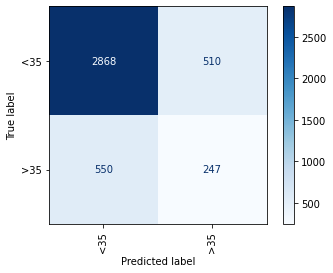

In [39]:
cm = confusion_matrix(y_test, y_pred, labels=gs.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=gs.classes_)
disp.display_labels = encoded_labels
disp.plot(cmap='Blues')
disp.ax_.tick_params(axis='x', rotation=90)
disp.ax_.set_facecolor('red');